This notebook demonstrates an implementation of a [Deep Q-Network](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) for training an agent to collect yellow bananas while avoiding blue bananas.

In [1]:
# general
import numpy as np
import torch

# environment and agent
from unityagents import UnityEnvironment
from dqn_agent import Agent

# plotting
from collections import deque
import matplotlib.pyplot as plt

# Setup the Unity game environment

In [2]:
env = UnityEnvironment(file_name="Banana_Linux_NoVis/Banana.x86")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]


print('Number of agents:', len(env_info.agents))

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

state = env_info.vector_observations[0]
print('States look like:\n', state)
state_size = len(state)
print('States have length:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like:
 [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


# Define the function that runs and trains the agent

The training stops when the mean of the rolling window of 100 most recent scores is at least SCORE_THRESHOLD, or 13.0.

In [3]:
def run(agent, n_episodes=3000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, train=True, SCORE_THRESHOLD=13.0, log=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train)[brain_name]

        state = env_info.vector_observations[0]            # get the current state
        score = 0
        eps = 0.0 if not train else eps
        
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished            
            
            if train: 
                agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            
            if done:
                break 
        
        if log: 
            print('Score: {:.0f}'.format(score), end="\n")
        
        scores_window.append(score)       # save most recent score into the rolling window
        scores.append(score)              # save most recent score into list of all scores
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=SCORE_THRESHOLD and train:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pt')
            break
    return scores

# Instantiate the agent and train it using a Deep Q-Network.

Here, state_size=37 (continuous space) and action_size=4 (discrete space)

In [4]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

Agent set up on device cuda:0


Episode 100	Average Score: 0.68
Episode 200	Average Score: 3.21
Episode 300	Average Score: 7.01
Episode 400	Average Score: 9.75
Episode 500	Average Score: 11.69

Environment solved in 452 episodes!	Average Score: 13.06


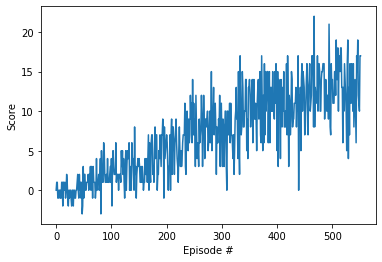

In [5]:
scores = run(agent)
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Run the trained agent

In [6]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
agent.load_state('checkpoint.pt')
scores = run(agent, n_episodes=100, train=False)

Agent set up on device cuda:0
Loading pretrained network from checkpoint.pt
Episode 100	Average Score: 14.55
